# Dataset Generation (Nonmarkov)

Style <-/-> Digit -> color-digit <-> color-bar

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import scipy.stats
import seaborn as sns
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
import torchvision.transforms.functional as F
from joblib import Parallel, delayed
from PIL import Image
from scipy import stats
from scipy.stats import truncnorm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import (
    CausalBarMNIST,
    MultiDistrDataModule,
    alter_digitbar_img,
    nonmarkov_bar_digit_scm,
)
from gendis.datasets.morphomnist import morpho, perturb
from gendis.datasets.utils import show_imgs

plt.rcParams["savefig.bbox"] = "tight"
import numpy as np
import seaborn as sns

In [3]:
root = "/Users/adam2392/pytorch_data/"

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        # nf.utils.Jitter(1 / 256.0),  # apply random generation
        # torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

mnist_data = MNIST(root, train=True, download=True, transform=transform)

images = mnist_data.data
labels = mnist_data.targets

print(len(images))

60000


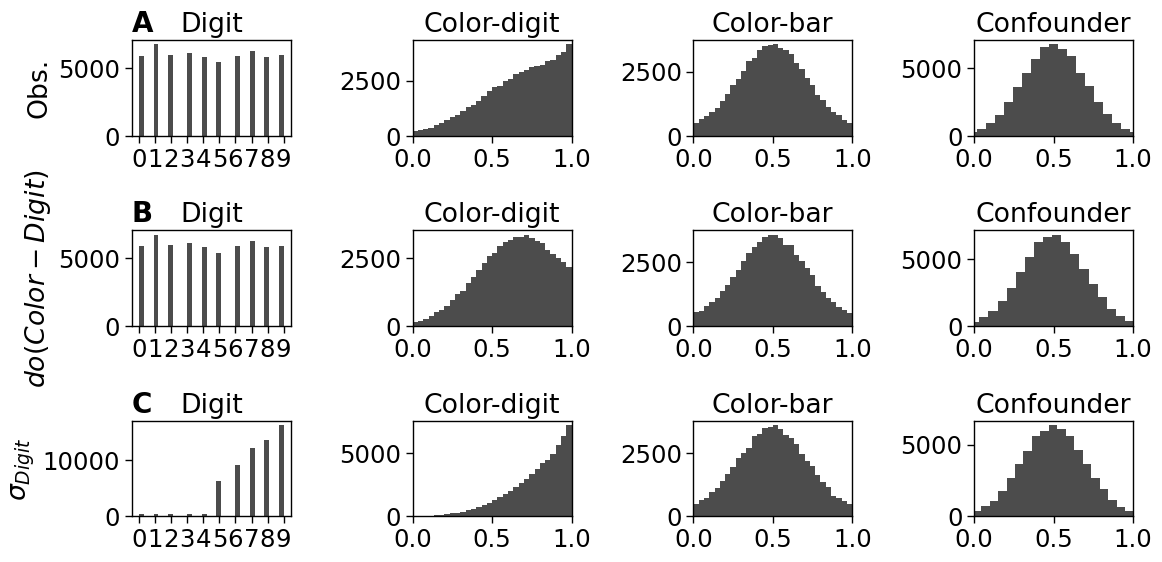

In [11]:
sns.set_context("paper", font_scale=2.0)

# Plotting the distributions
fig, axes = plt.subplots(3, 4, figsize=(12, 6), sharex=False, sharey=False)
row_labels = ["A", "B", "C"]
for idx in range(3):
    causal_labels = nonmarkov_bar_digit_scm(intervention_idx=idx, labels=labels)
    if idx == 0:
        setting = "Obs."
    elif idx == 1:
        setting = "$do({{Color-Digit}})$"
    elif idx == 2:
        setting = "$\sigma_{{Digit}}$"
    # axes[idx, 0].set_ylabel(f"{setting}")
    axes[idx, 0].set_ylabel(f"{setting}")

    digit = causal_labels["digit"]
    color_digit = causal_labels["color_digit"]
    color_bar = causal_labels["color_bar"]
    confounder = causal_labels["confounder"]

    axes[idx, 0].hist(digit, bins=30, color="black", alpha=0.7)
    axes[idx, 0].set_title(f"Digit")
    axes[idx, 0].set_xticks(range(10))
    axes[idx, 1].hist(color_digit, bins=30, color="black", alpha=0.7)
    axes[idx, 1].set_title(f"Color-digit")
    axes[idx, 1].set_xlim([0, 1])
    axes[idx, 1].set_xticks([0, 0.5, 1])
    axes[idx, 2].hist(color_bar, bins=30, color="black", alpha=0.7)
    axes[idx, 2].set_title(f"Color-bar")
    axes[idx, 2].set_xlim([0, 1])
    axes[idx, 2].set_xticks([0, 0.5, 1])
    axes[idx, 3].hist(confounder, bins=30, color="black", alpha=0.7)
    axes[idx, 3].set_title(f"Confounder")
    axes[idx, 3].set_xlim([0, 1])
    axes[idx, 3].set_xticks([0, 0.5, 1])

    # axes[idx, 0].text(
    #     1.0,
    #     20.0,
    #     row_labels[idx],
    #     # transform=axes[idx, 2].transAxes,
    #     fontsize=20,
    #     fontweight="bold",
    #     # va="top",
    #     # ha="right",
    # )
    # Set the letter as the title of the [idx, 0] figure and position it to the top-right
    axes[idx, 0].set_title(row_labels[idx], loc="left", fontsize=20, fontweight="bold")

plt.tight_layout()
# fig.savefig(
#     "/Users/adam2392/Downloads/mnist-colorbar-distributions.pdf", bbox_inches="tight"
# )
# plt.show()

In [14]:
img_dataset = []
labels_dataset = None

for intervention_idx in range(3):
    causal_labels, digit_idx = nonmarkov_bar_digit_scm(
        intervention_idx=intervention_idx, labels=labels
    )
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    keys = causal_labels.keys()
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    distr_images = images[digit_idx]
    for idx, img in enumerate(distr_images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar, dtype="PIL")
        img_dataset.append(new_img)

        # Uncomment to show the images
        if idx >= 7:
            break

img_dataset = torch.vstack(
    [
        torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
        for x in img_dataset
    ]
)

print(img_dataset.shape)
print(labels_dataset.keys())

torch.Size([24, 3, 28, 28])
dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'confounder', 'distr_idx'])


torch.Size([24, 3, 28, 28])
8 3


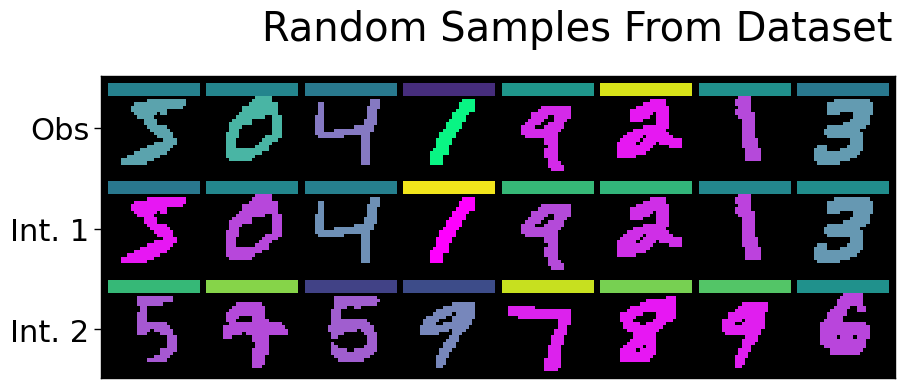

In [15]:
print(img_dataset.shape)
sns.set_context("paper", font_scale=2.5)
fig, ax = show_imgs(
    img_dataset,
    row_size=8,
    ytick_labels=["Obs", "Int. 1", "Int. 2", "Int. 3", "Int. 4"],
)
fig.suptitle("Random Samples From Dataset", x=0.6, y=0.9)
fig.tight_layout()
fig.savefig(
    "/Users/adam2392/Downloads/sample_nonmarkov_dataset.pdf", bbox_inches="tight"
)

# Generate the full dataset

In [19]:
img_dataset = []
labels_dataset = None

for intervention_idx in range(3):
    causal_labels, digit_idx = nonmarkov_bar_digit_scm(
        intervention_idx=intervention_idx, labels=labels
    )
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    keys = causal_labels.keys()
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    distr_images = images[digit_idx]
    for idx, img in enumerate(distr_images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar, dtype="PIL")
        img_dataset.append(new_img)

        # Uncomment to show the images
        # if idx >= 7:
        #     break

# img_dataset = torch.vstack(
#     [
#         torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
#         for x in img_dataset
#     ]
# )

# print(img_dataset.shape)
print(labels_dataset.keys())

dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'confounder', 'distr_idx'])


In [20]:
print(labels_dataset.keys())
keys = ["digit", "color_digit", "color_bar", "distr_idx"]
label_tensor = torch.zeros((len(img_dataset), len(keys)))
# convert the labels from a list of dictionaries to a tensor array
for idx, key in enumerate(keys):
    label_tensor[:, idx] = torch.Tensor(labels_dataset[key]).squeeze()
print(label_tensor.shape)

intervention_target_tensor = torch.zeros((len(img_dataset), 3), dtype=torch.int)
intervention_target_tensor[:] = torch.Tensor(labels_dataset["intervention_targets"])
print(intervention_target_tensor.shape)
print(root)

# save the actual data to disc now
root = Path(root)
imgs_fname = root / "CausalDigitBarMNIST" / "nonmarkov" / "nonmarkov-imgs-train.pt"
labels_fname = root / "CausalDigitBarMNIST" / "nonmarkov" / "nonmarkov-labels-train.pt"
targets_fname = (
    root / "CausalDigitBarMNIST" / "nonmarkov" / "nonmarkov-targets-train.pt"
)
imgs_fname.parent.mkdir(exist_ok=True, parents=True)

torch.save(img_dataset, imgs_fname)
torch.save(label_tensor, labels_fname)
torch.save(intervention_target_tensor, targets_fname)

dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'confounder', 'distr_idx'])
torch.Size([180000, 4])
torch.Size([180000, 3])
/Users/adam2392/pytorch_data


In [21]:
unique_rows = np.unique(intervention_target_tensor, axis=0)
print("Unique intervention targets: ", unique_rows)

Unique intervention targets:  [[0 0 0]
 [0 1 0]
 [1 0 0]]
